Notebook where we are trying to understanding maskbits

In [12]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist
from desi_lowz_funcs import find_objects_nearby, make_subplots, sdss_rgb
from construct_dwarf_galaxy_catalogs import process_sga_matches
from aperture_photo import make_new_saturated_mask


In [32]:
from aperture_photo import make_new_saturated_mask, get_binary_mask

In [ ]:
# make_new_saturated_mask(img_data, mask_data, invvar_data, noise_dict,plot=False)



In [5]:
tot_shred = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")



In [6]:
img_path = tot_shred[tot_shred["TARGETID"] == 39627758254424586]["IMAGE_PATH"][0]

maskbits = fits.open(img_path)[2].data
invvar = fits.open(img_path)[1].data
data = fits.open(img_path)[0].data


In [36]:
bin_mask = get_binary_mask(maskbits).astype(int)

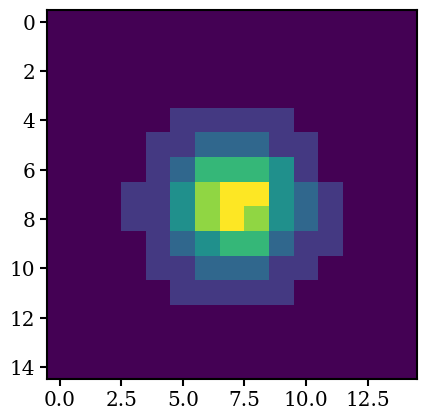

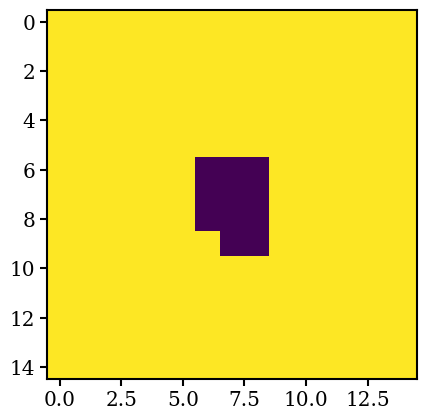

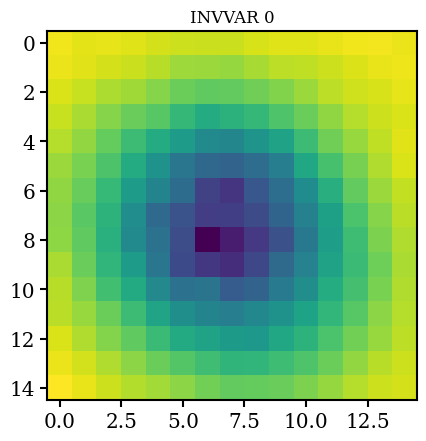

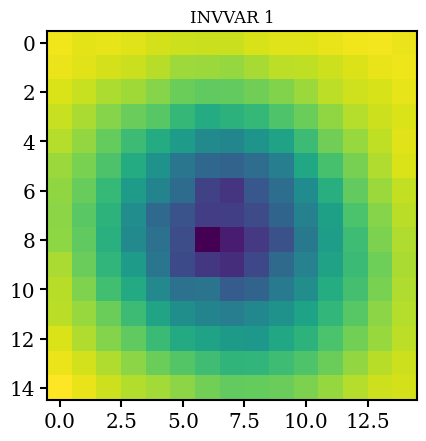

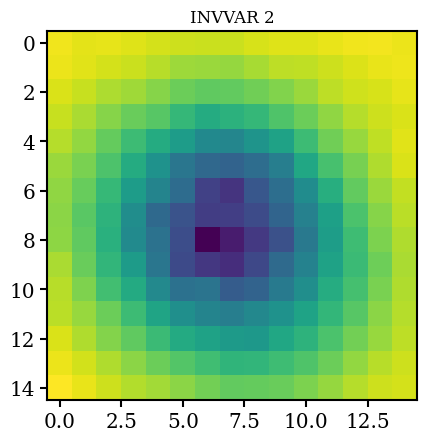

In [37]:
plt.imshow(maskbits[165:180,170:185])
plt.show()

plt.imshow(bin_mask[165:180,170:185])
plt.show()


for i in range(3):
    plt.title(f"INVVAR {i}")
    plt.imshow(invvar[0,165:180,170:185],norm=LogNorm())
    plt.show()

In [31]:
np.unique(maskbits[165:180,170:185])

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [47]:
(np.array([0,1,2,3,4,5,6]) & 2**3)==0

array([ True,  True,  True,  True,  True,  True,  True])

Making the final plot:

In [4]:
from photutils.background import StdBackgroundRMS, MADStdBackgroundRMS
from astropy.stats import SigmaClip
from scipy.ndimage import binary_dilation
from aperture_photo import get_binary_mask



In [24]:
temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")
temp_bgsb = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")


In [25]:
def prep_data(targetid, temp=temp):
    '''
    39633038857996674
    '''
    
    temp_f = temp[temp["TARGETID"] == targetid]
        
    
    hdus = fits.open(temp_f["IMAGE_PATH"][0])
    
    img_data = hdus[0].data
    invv_data = hdus[1].data
    mask_data = hdus[2].data

    
    #first estimate the background error to use in aperture photometry
    noise_dict = {}
    
    rms_estimator = MADStdBackgroundRMS()
    ##estimate the background rms in each band!
    for i,bii in enumerate(["g","r","z"]):        
        # Apply sigma clipping
        sigma_clip = SigmaClip(sigma=3.0,maxiters=5)
        clipped_data = sigma_clip(img_data[i])
        # Estimate RMS
        background_rms = rms_estimator(clipped_data)
        noise_dict[bii] = background_rms

    return img_data, invv_data, mask_data, noise_dict, temp_f["RA"][0], temp_f["DEC"][0] 


In [98]:
from aperture_photo import get_binary_mask

def get_binary_allmask(mask_data_array):
    '''
    Input is the mask bit array
    '''

    maskclean = np.ones_like(mask_data_array, dtype=bool)
    set_maskbits = [5, 6, 7]         
    for bit in set_maskbits:
        maskclean &= (mask_data_array & 2**bit)==0
    
    maskclean = maskclean.astype(mask_data_array.dtype)

    return maskclean.astype(bool)
    
def make_cutout(img, cutout_size):
    org_size = np.shape(img)[1]
    start = (org_size - cutout_size) // 2  # assumes square images
    end = start + cutout_size
    if len(np.shape(img)) == 3:
        img = img[:, start:end, start:end]
    else:
        img = img[start:end, start:end]
    return img

def make_new_saturated_mask(img_data, mask_data, invvar_data, noise_dict,plot=False,cutout_size = 350):
    '''
    This function updates the mask constructed using the MASKBITS = 2,3,4.
    Basically, it takes the original mask constructed, and then subselects the pixels from that to select!

    Noise_dict is the dictionary of rms values per band
    '''

    #we will do cutouts centered on the img_data, mask_data, and invvar_data

    img_data = make_cutout(img_data, cutout_size)
    mask_data = make_cutout(mask_data, cutout_size)
    invvar_data = make_cutout(invvar_data, cutout_size)
    
    #this is True for good pixels, False for bad pixrls
    bin_mask = get_binary_mask(mask_data)

    #getting the binary mask using the 5,6,7 maskbits
    bin_mask_567 = get_binary_allmask(mask_data)
    
    gimg,rimg,zimg = img_data[0],img_data[1],img_data[2]
    
    gr_img = gimg - rimg
    rz_img = rimg - zimg
    
    sig_g_arr = gimg/noise_dict["g"]
    sig_r_arr = rimg/noise_dict["r"] 
    sig_z_arr = zimg/noise_dict["z"]

    #construct the mask that has 200 sigma detection above rms in at least one band
    # sig_limit = 200
    # sig_grz_mask = (sig_g_arr > sig_limit) | (sig_r_arr > sig_limit) | (sig_z_arr > sig_limit)

    # color_mask = (np.abs(gr_img) > 2) | (np.abs(rz_img) > 2)

    #we also mask pixels where the inverse variance is zero in at least one of the 3 bands
    inv_mask = (invvar_data[0]== 0) | (invvar_data[1]== 0) | (invvar_data[2]== 0)

    # final_mask = ((~bin_mask) & sig_grz_mask) | ( (~bin_mask) & color_mask ) | (inv_mask)
    final_mask = inv_mask
    
    ##once I have mask, how to grow it a bit!
    # Apply dilation (repeat to grow by 2 pixels)
    structure = np.ones((3, 3), dtype=bool)
    final_mask_pd = binary_dilation(final_mask, structure=structure, iterations=4)

    if plot:
        grz_img = sdss_rgb(img_data)
        #make a color color plot of these saturated pixels
        fs = 18
        fig,ax = plt.subplots(1,6,figsize = (30,5),sharex=True,sharey=True)
        plt.subplots_adjust(wspace=0.1)
        ax[0].set_title("grz data",fontsize = fs)
        ax[0].imshow(grz_img)
        ax[1].set_title("MASKBITS = 2,3,4",fontsize = fs)
        ax[1].imshow(bin_mask)
        ax[2].set_title("MASKBITS = 5,6,7",fontsize = fs)
        ax[2].imshow(bin_mask_567)
        grz_img_copy = np.copy(grz_img)
        grz_img_copy[~bin_mask] = 0
        ax[3].set_title("Original Mask grz data",fontsize = fs)
        ax[3].imshow(grz_img_copy)
        grz_img_copy = np.copy(grz_img)
        grz_img_copy[final_mask] = 0
        ax[4].set_title("Updated Mask, Pre Dilate",fontsize = fs)
        ax[4].imshow(grz_img_copy)
        grz_img_copy = np.copy(grz_img)
        grz_img_copy[final_mask_pd] = 0
        ax[5].set_title("Updated Mask, Post Dilate",fontsize = fs)
        ax[5].imshow(grz_img_copy)
        
        plt.show()
    
    #we invert it as we want to return a mask of all the good pixels!    
    return ~final_mask_pd


            

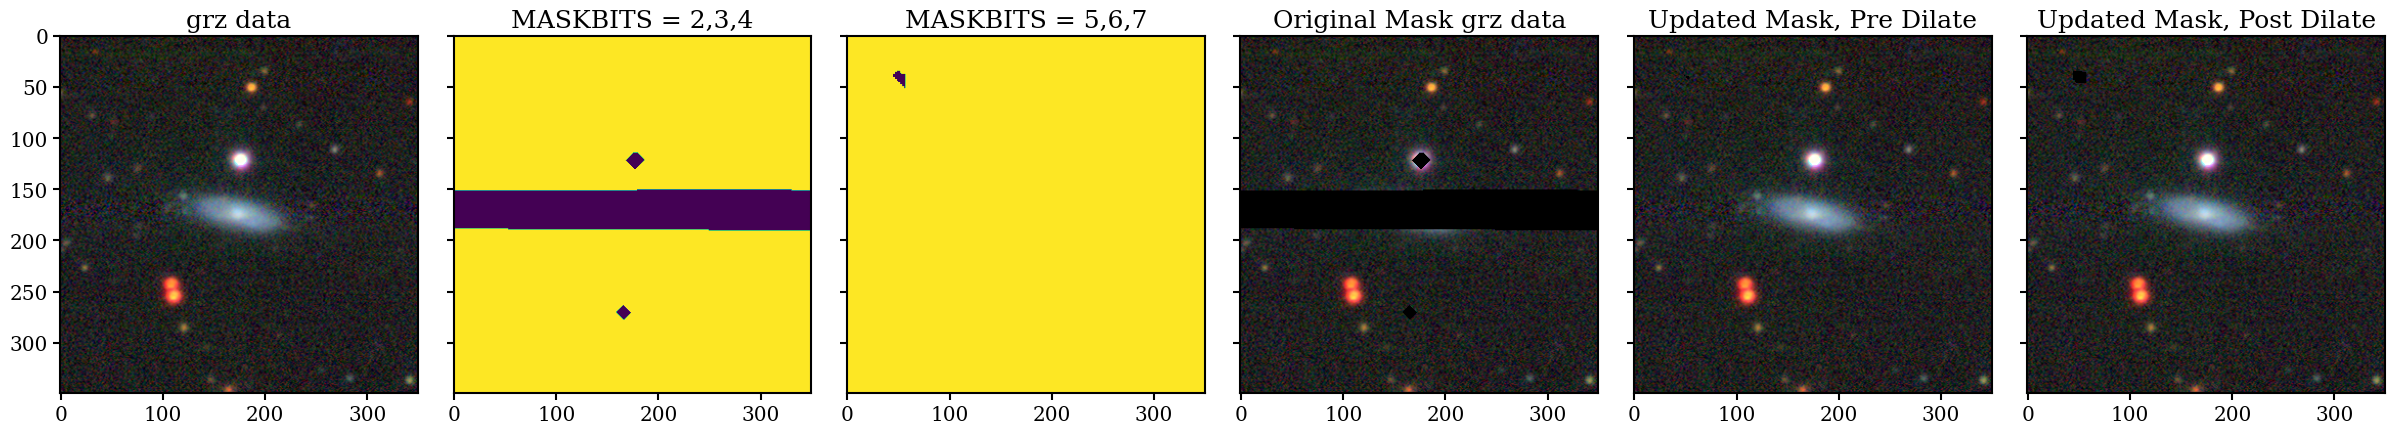

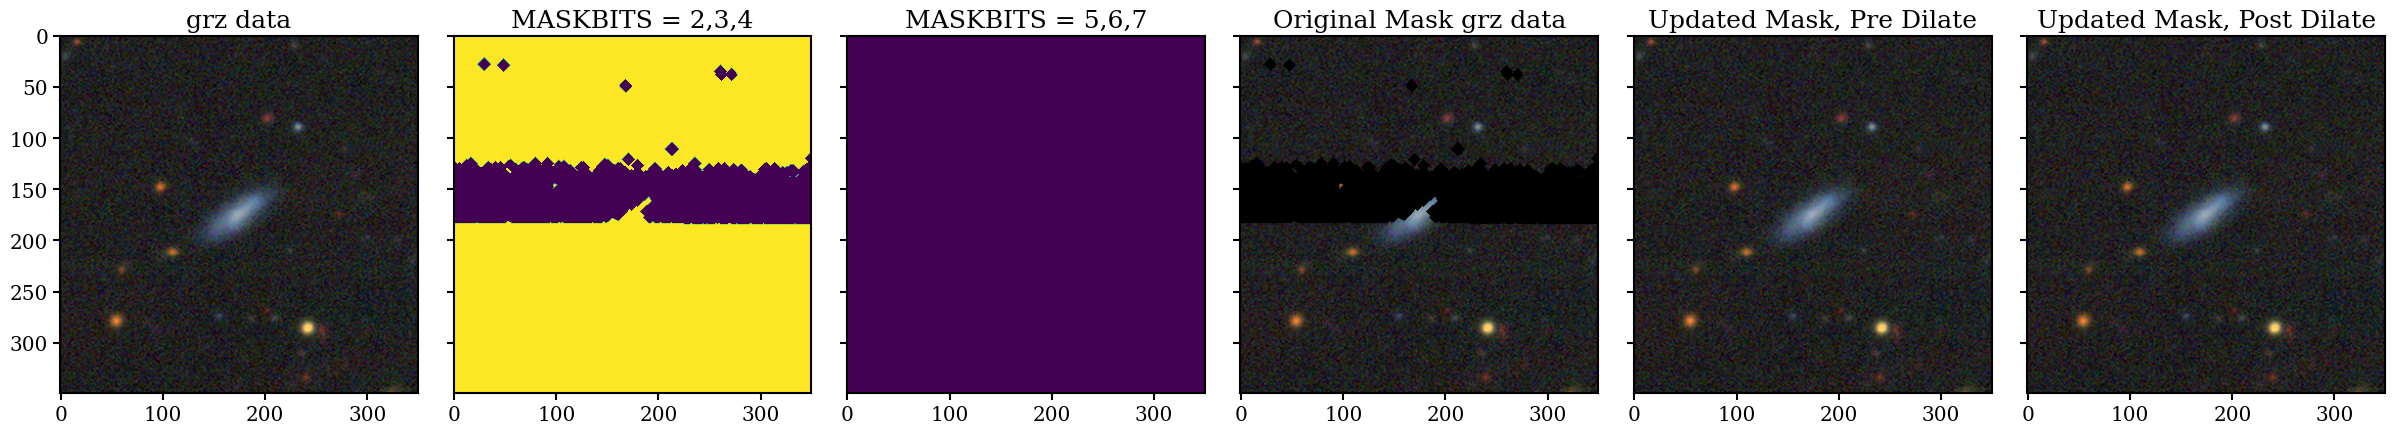

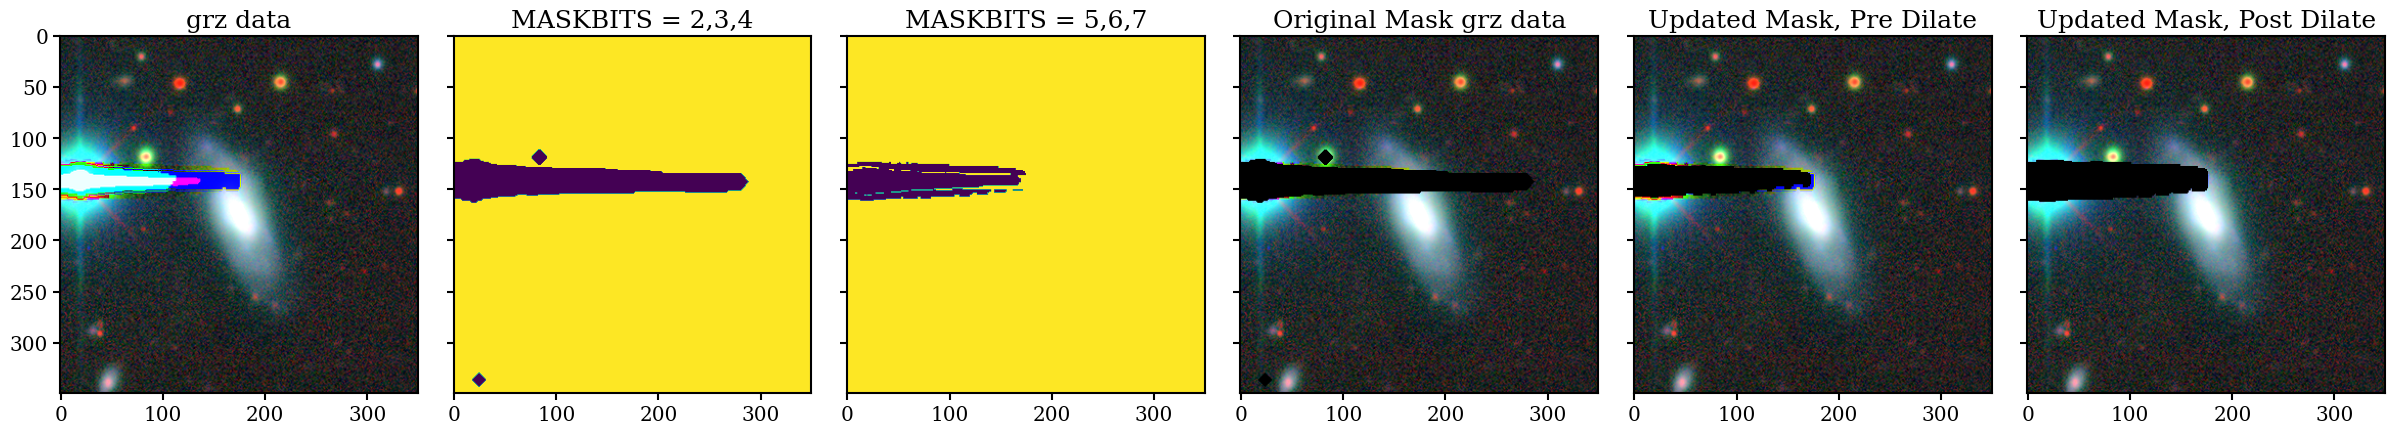

In [99]:

img_data, invv_data, mask_data, noise_dict,ra,dec = prep_data(39633038857996674)
_ = make_new_saturated_mask(img_data, mask_data, invv_data, noise_dict,plot=True)


img_data, invv_data, mask_data, noise_dict,ra,dec = prep_data(39632990178904830)
_ = make_new_saturated_mask(img_data, mask_data, invv_data, noise_dict,plot=True)

img_data, invv_data, mask_data, noise_dict,ra,dec = prep_data(39633475078195003)
_ = make_new_saturated_mask(img_data, mask_data, invv_data, noise_dict,plot=True)



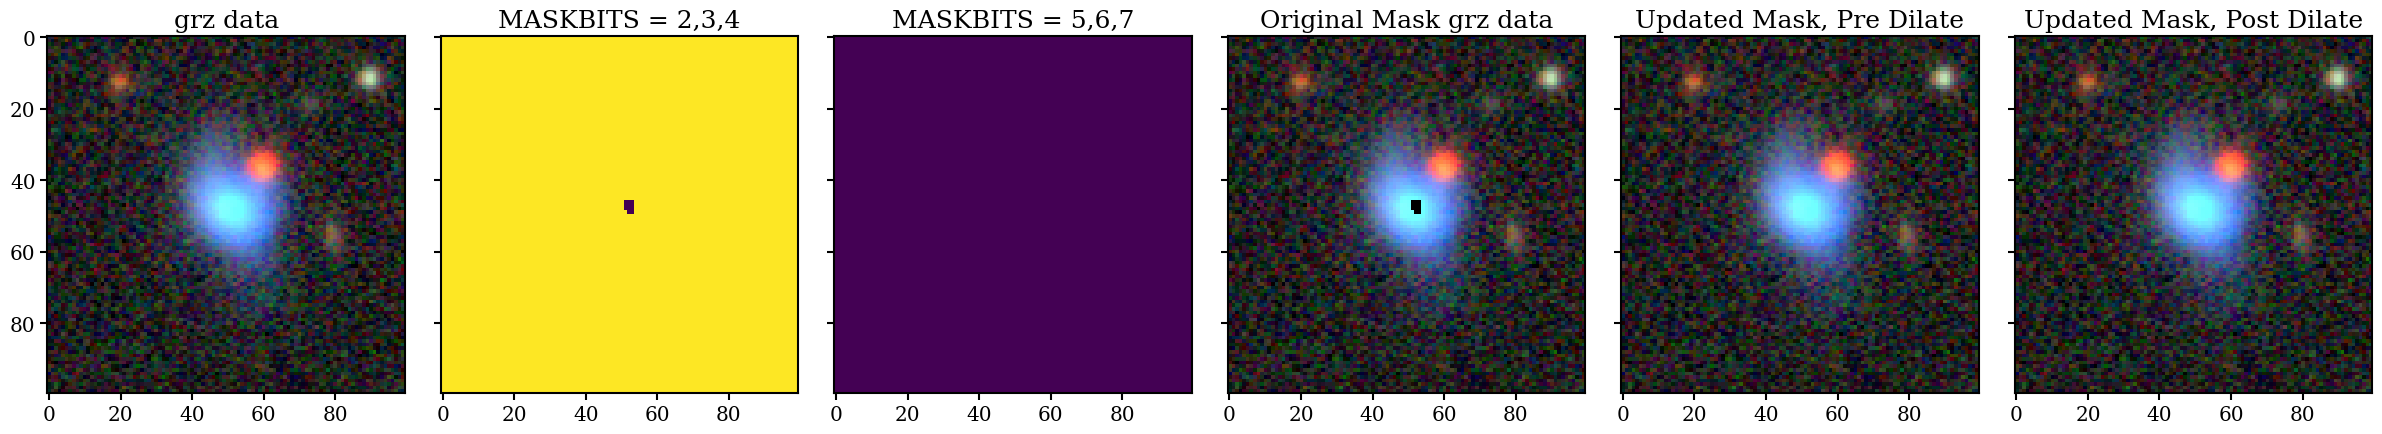

In [45]:
img_data, invv_data, mask_data, noise_dict,ra,dec = prep_data(39627758254424586, temp_bgsb)
_ = make_new_saturated_mask(img_data, mask_data, invv_data, noise_dict,plot=True,cutout_size=100)


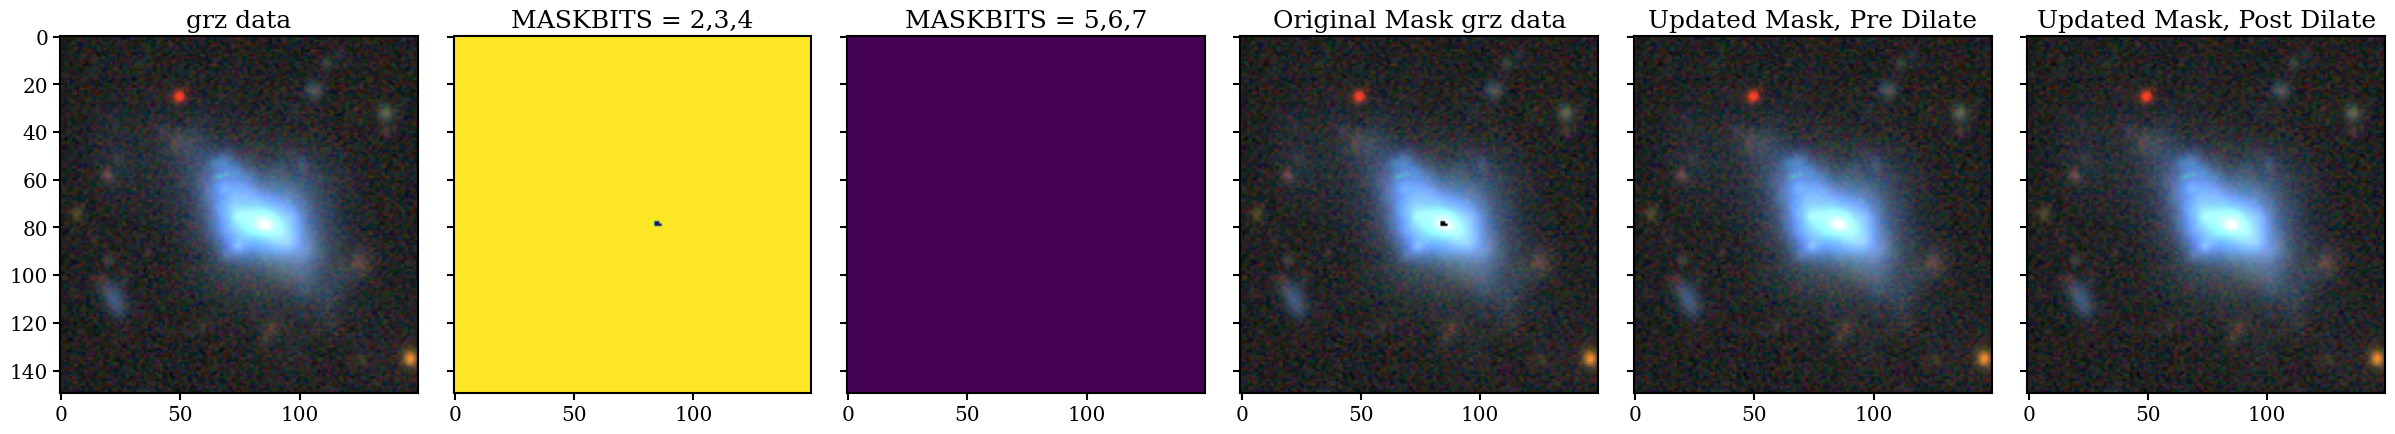

In [46]:
img_data, invv_data, mask_data, noise_dict,ra,dec = prep_data(39627803485805800, temp_bgsb)
_ = make_new_saturated_mask(img_data, mask_data, invv_data, noise_dict,plot=True,cutout_size=150)


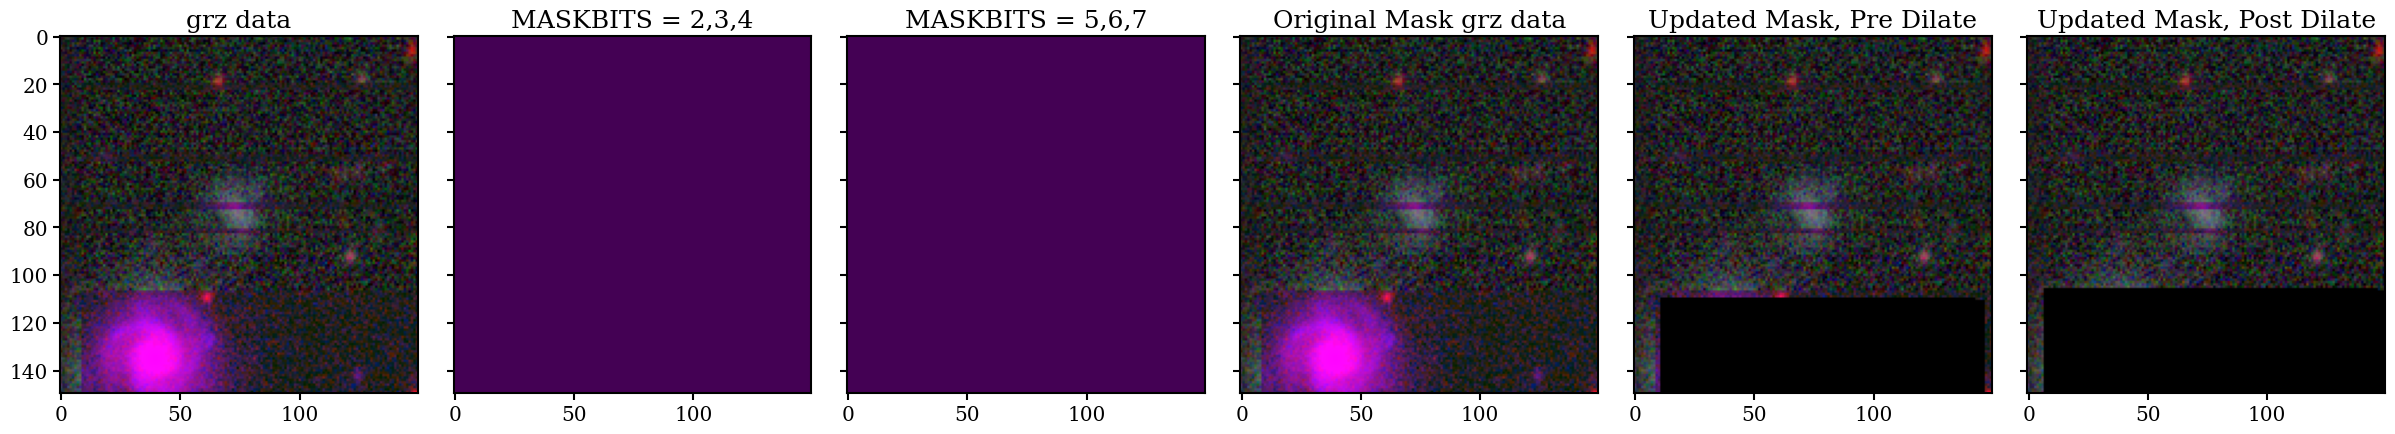

In [47]:
img_data, invv_data, mask_data, noise_dict,ra,dec = prep_data(39627709294317784, temp_bgsb)
_ = make_new_saturated_mask(img_data, mask_data, invv_data, noise_dict,plot=True,cutout_size=150)


In [100]:


def make_masking_panel(ax, img_data, mask_data, invvar_data, cutout_size = 350,plot_title = False):

    
    img_data = make_cutout(img_data, cutout_size)
    mask_data = make_cutout(mask_data, cutout_size)
    invvar_data = make_cutout(invvar_data, cutout_size)

    org_size = np.shape(img_data)[1]
    
    #this is True for good pixels, False for bad pixrls
    bin_mask = get_binary_mask(mask_data)

    #getting the binary mask using the 5,6,7 maskbits
    bin_mask_567 = get_binary_allmask(mask_data)

    #the updated mask
    final_mask = (invvar_data[0]== 0) | (invvar_data[1]== 0) | (invvar_data[2]== 0)

    structure = np.ones((3, 3), dtype=bool)
    final_mask_pd = binary_dilation(final_mask, structure=structure, iterations=4)


    ##making the actual plot now
    grz_img = sdss_rgb(img_data)
    #make a color color plot of these saturated pixels
    fs = 18

    if plot_title:
        ax[0].set_title(r"$grz$ image",fontsize = fs)
        ax[1].set_title("MASKBITS = 2,3,4",fontsize = fs)
        ax[2].set_title("MASKBITS = 5,6,7",fontsize = fs)
        ax[3].set_title("INVVAR=0 + Dilation",fontsize = fs)

    
    ax[0].imshow(grz_img,origin="lower")
    
    grz_img_copy = np.copy(grz_img)
    grz_img_copy[~bin_mask] = 0
    ax[1].imshow(grz_img_copy,origin="lower")
    
    grz_img_copy = np.copy(grz_img)
    grz_img_copy[~bin_mask_567] = 0
    ax[2].imshow(grz_img_copy,origin="lower")
    
    grz_img_copy = np.copy(grz_img)
    grz_img_copy[final_mask_pd] = 0
    ax[3].imshow(grz_img_copy,origin="lower")

    ##add the cutout size 

    bar_frac = 15/(org_size * 0.262)

    x_start_frac = 0.07  # 7% from left
    y_start_frac = 0.07  # 7% from bottom
    
    # Draw the scale bar in axes coordinates
    ax[0].plot([x_start_frac, x_start_frac + bar_frac],
            [y_start_frac, y_start_frac],
            color='white', lw=1, transform=ax[0].transAxes)    
    fs=14
    ax[0].text( x_start_frac + 0.25*bar_frac, y_start_frac*1.1, r"$15''$",fontsize = fs,color = "white", transform=ax[0].transAxes )
    
    #also include ra,dec at top
    ax[0].text(0.5,0.95,"(%.3f, %.3f)"%(ra,dec),size =fs,transform=ax[0].transAxes,
               verticalalignment='top',color = "white",horizontalalignment="center")

    for axi in ax:
        axi.set_xticks([])
        axi.set_yticks([])
    
    return

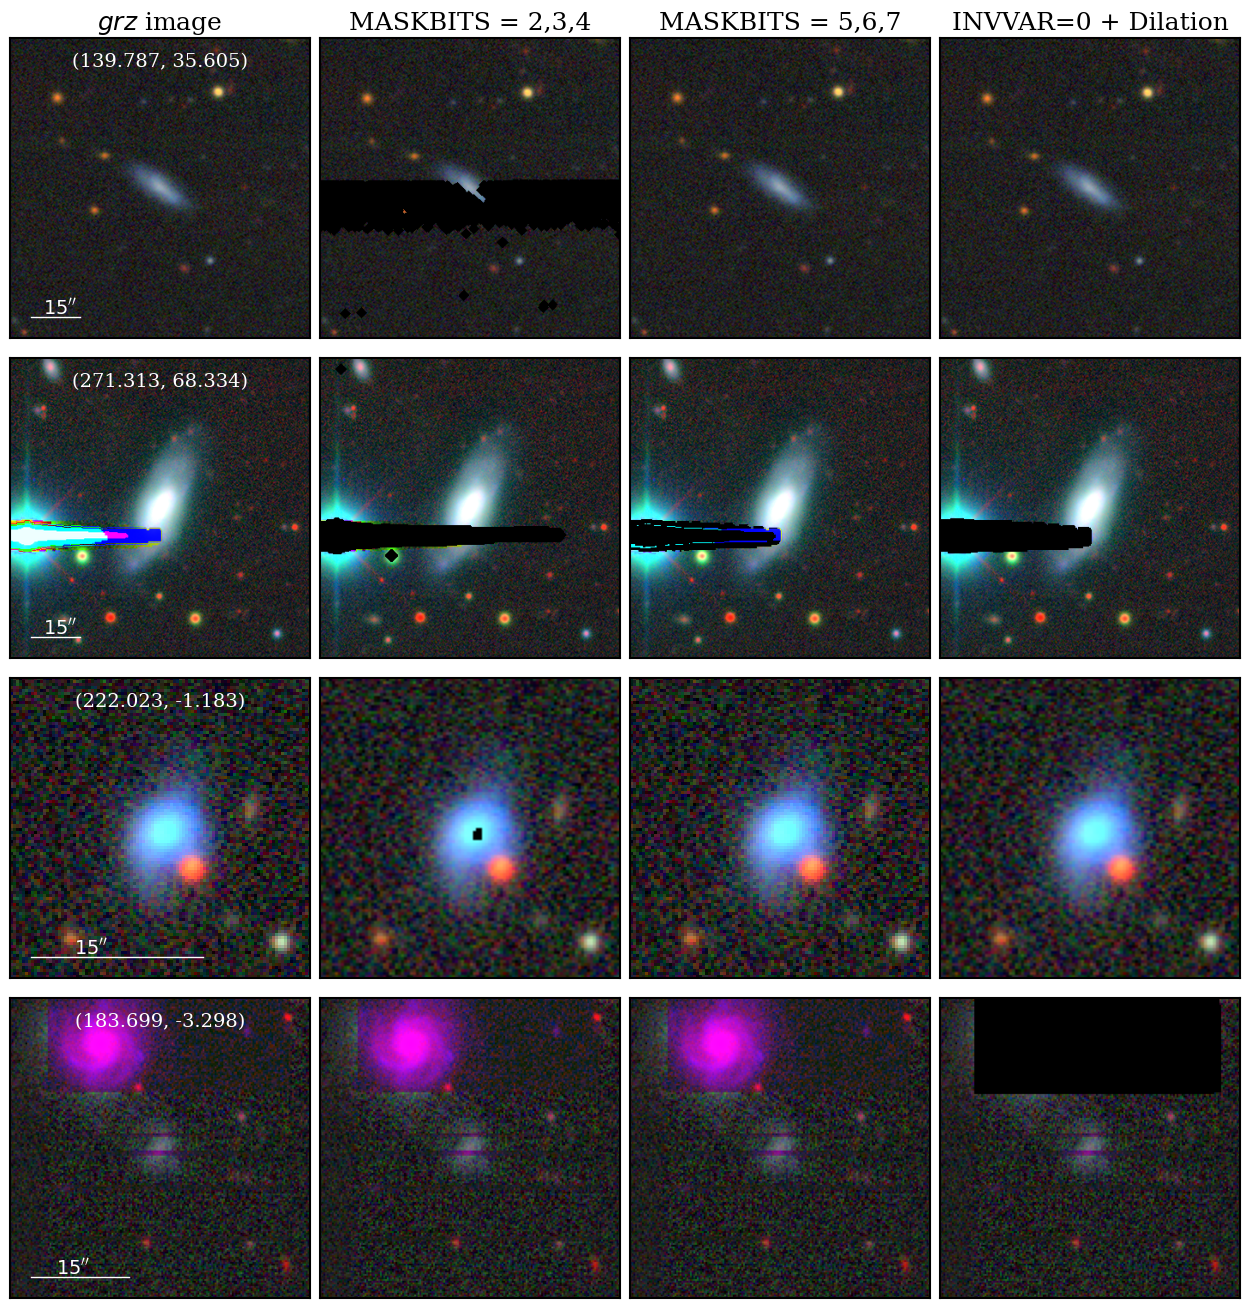

In [94]:

fig,ax = make_subplots(ncol = 4, nrow = 4, return_fig=True, row_spacing = 0.2,col_spacing = 0.1,)

img_data, invv_data, mask_data, noise_dict,ra,dec = prep_data(39627709294317784, temp_bgsb)
make_masking_panel( [ax[0],ax[1],ax[2],ax[3]] , img_data, mask_data, invv_data, cutout_size = 175)


img_data, invv_data, mask_data, noise_dict,ra,dec = prep_data(39627758254424586, temp_bgsb)
make_masking_panel( [ax[4],ax[5],ax[6],ax[7]] , img_data, mask_data, invv_data, cutout_size = 100)


img_data, invv_data, mask_data, noise_dict,ra,dec = prep_data(39633475078195003)
make_masking_panel( [ax[8],ax[9],ax[10],ax[11]] , img_data, mask_data, invv_data, cutout_size = 350)

img_data, invv_data, mask_data, noise_dict,ra,dec = prep_data(39632990178904830)
make_masking_panel( [ax[12],ax[13],ax[14],ax[15]] , img_data, mask_data, invv_data, cutout_size = 350,plot_title=True)

plt.savefig("plots/saturated_pixel_mask.pdf",bbox_inches="tight")
plt.show()
